# About<a id='about'></a>
This project's goal is to detect fraudulent credit card transactions, ensuring that customers are not charged for items they did not purchase. It is crucial for credit card companies to recognize such activities to protect their clients.

This dataset is highly imbalanced and contains transactions from two days, with 492 frauds out of 284,807 transactions. The dataset contains only numerical input variables resulting from a PCA transformation. Due to confidentiality issues, we cannot access the original features or more background information about the data. Features marked as 'V' are the principal components obtained through PCA. The only features not transformed with PCA are 'Time' and 'Amount'. The 'Time' feature represents the seconds elapsed between each transaction and the first transaction in the dataset, while the 'Amount' feature indicates the transaction amount.

Data imbalance presents a significant challenge in this project. Therefore, we will employ oversampling methods and compare models trained on modified datasets with those trained on the original data provided to us. The methods are oversampling and SMOTE.

# Table of content<a id='toc'></a>

0) [About](#about)
1) [EDA](#eda)
2) [Modeling](#modeling)
3) [Conclusion](#conclusion)

In [22]:
# general purposes imports
import collections
import os
# imports for csv
import pandas as pd
import numpy as np
from joblib import dump, load
from collections import Counter
# imports for visualization
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns

# imports for imbalanced dataset
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import Pipeline, make_pipeline

# imports for ML
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score, roc_auc_score, ConfusionMatrixDisplay
from sklearn.decomposition import PCA

from xgboost import XGBClassifier
from catboost import CatBoostClassifier


## EDA<a id='eda'></a>
[back to table of content](#toc)

In [2]:
df = pd.read_csv('creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

No missing values

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,1.168375e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,3.416908e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-1.379537e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.074095e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,9.604066e-16,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,1.487313e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-5.556467e-16,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,1.213481e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-2.406331e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


Amount is mostly under 77, but there is definetly an outlier with value greater than 25k. We may expect highly skewed data in Amount column.

/tmp/ipykernel_30768/4139641779.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


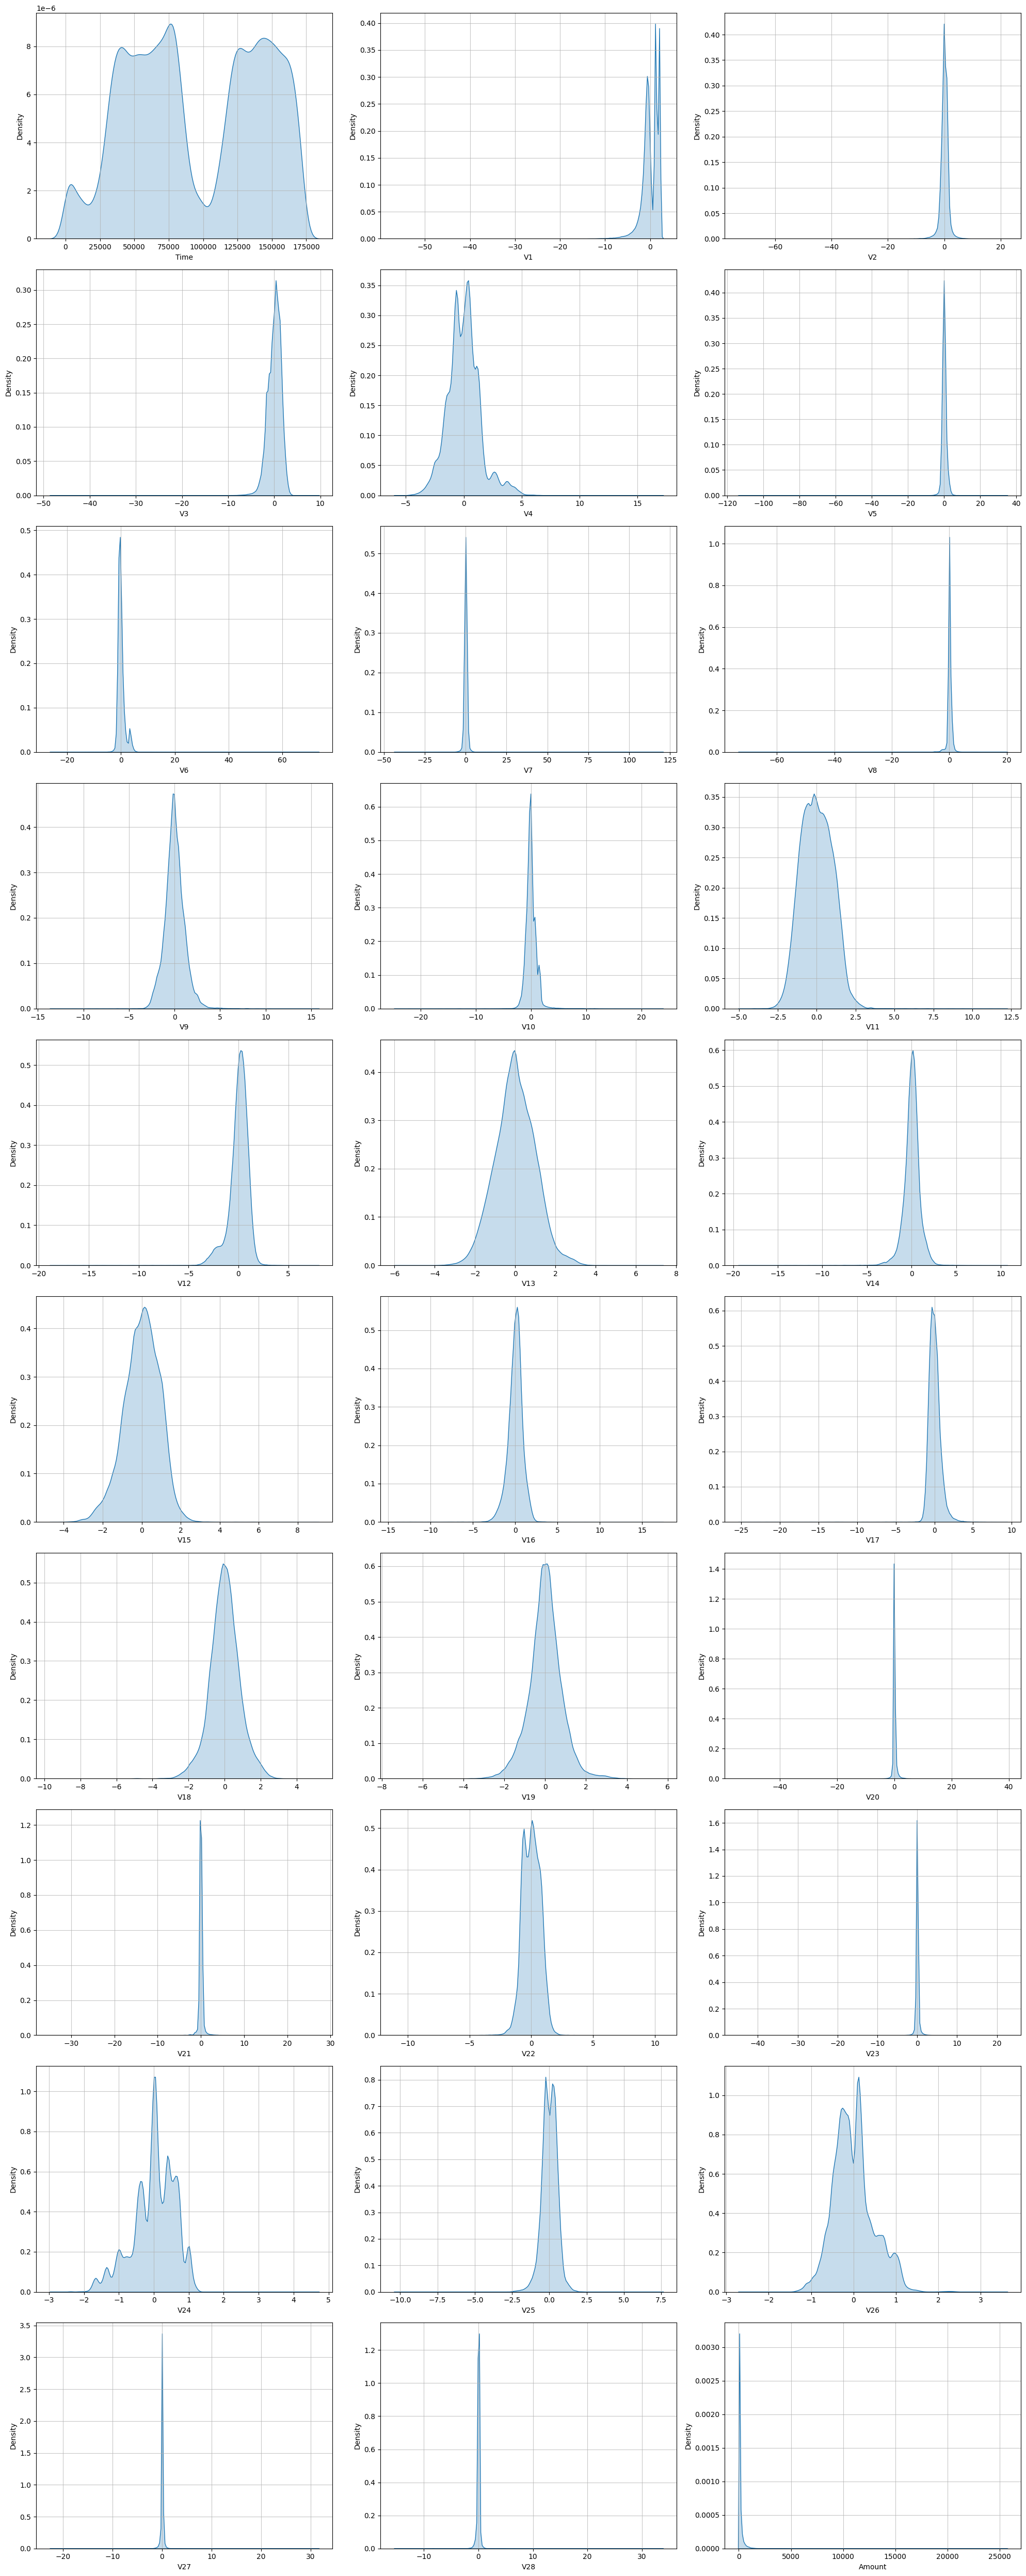

In [6]:
num_cols = list(df.loc[:,'Time':'Amount'])
fig = plt.figure(figsize=(20, 50))
rows, cols = 10, 3 

for idx, num in enumerate(num_cols[:30]):
    ax = fig.add_subplot(rows, cols, idx+1)
    ax.grid(alpha = 0.7, axis ="both")
    sns.kdeplot(x = num, fill = True, linewidth=1, data = df)
    ax.set_xlabel(num)
fig.tight_layout()
fig.show()

No data is normally distributed, and Amount is skewed as we expected. Loolks like transaction frequency is cycled. That makes sense: people are more active during daytime.

/tmp/ipykernel_30768/4074894371.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Normal','Fraud'])


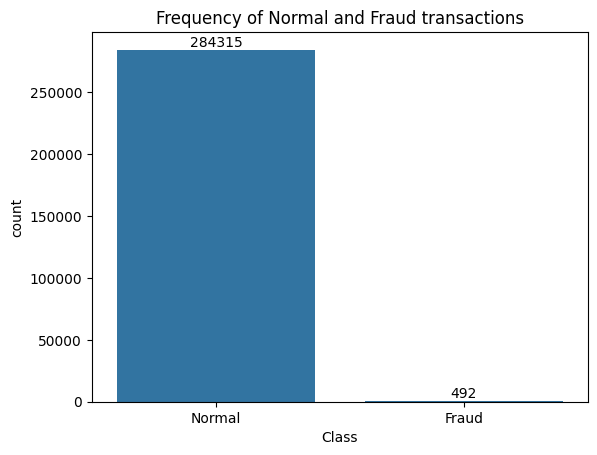

In [7]:
ax = sns.countplot(data = df, x='Class')
for i in ax.containers:
    ax.bar_label(i)
ax.set_xticklabels(['Normal','Fraud'])
    
plt.title('Frequency of Normal and Fraud transactions')
plt.show()

Very imbalanced data.

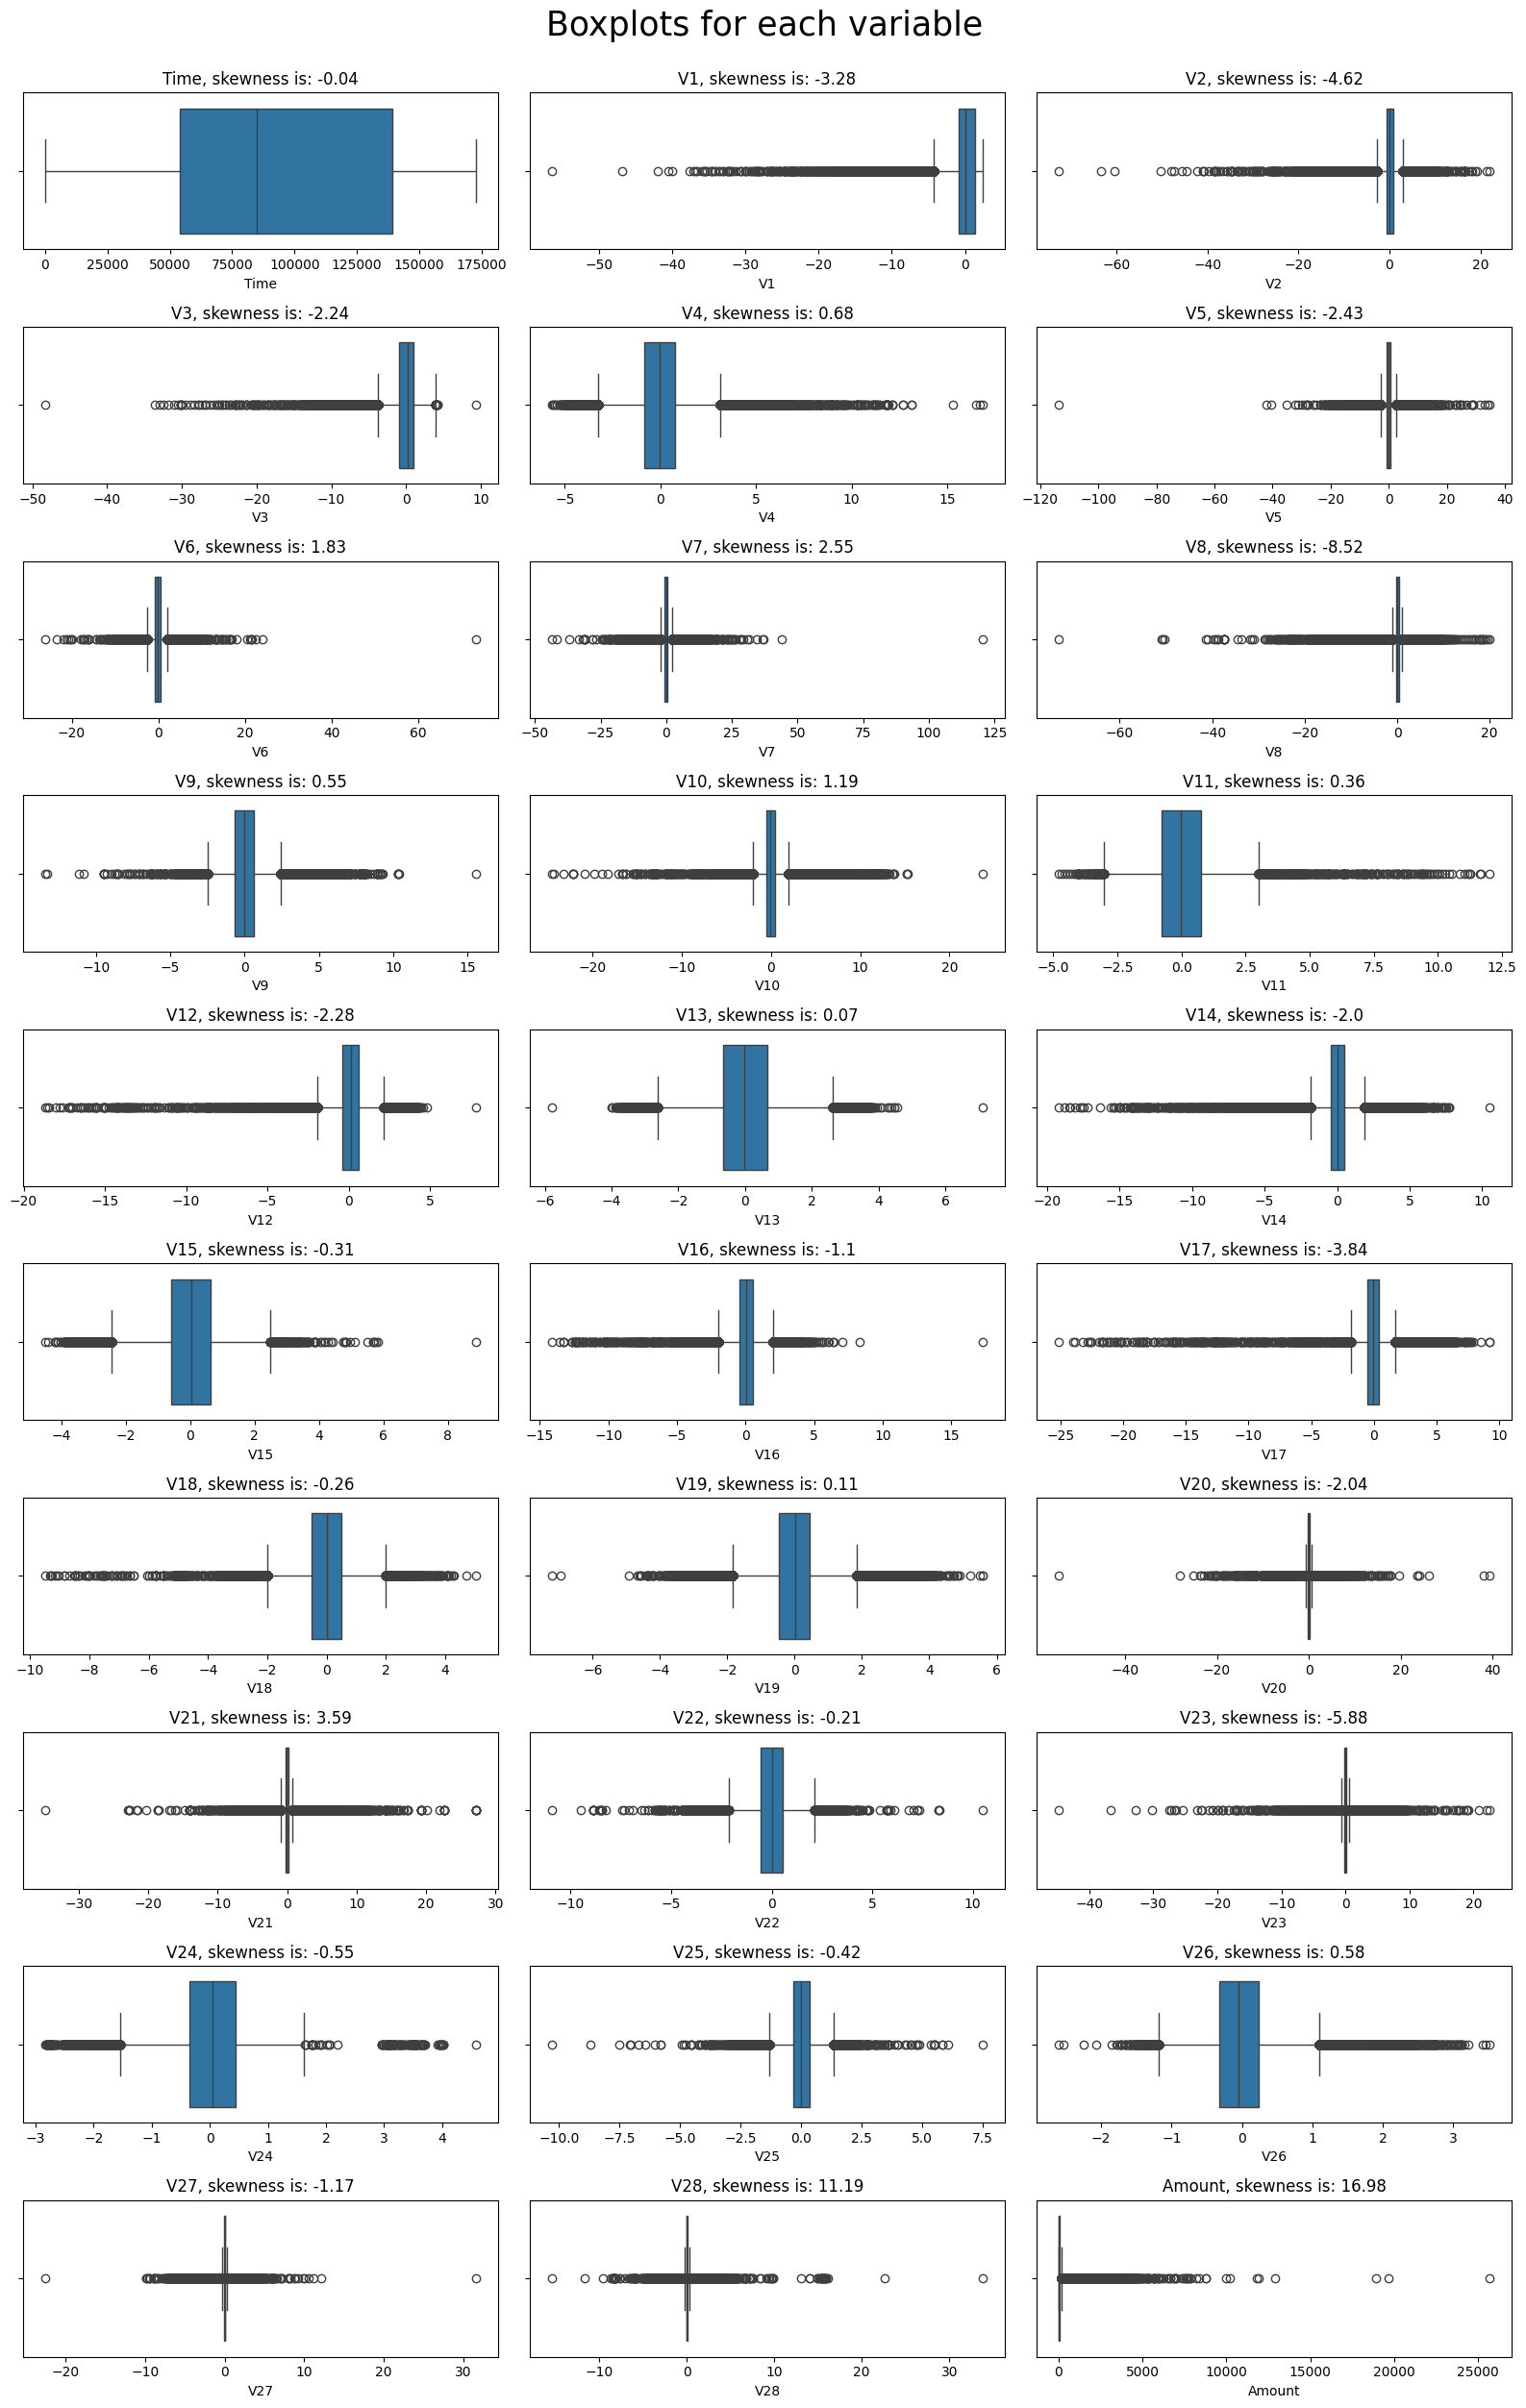

In [8]:
# checking boxplots
def boxplots_custom(df, columns_list, rows, cols, suptitle=''):
    
    assert rows>0 and cols>0, 'Amount of rows and colums must be greater than 0'
    assert set(columns_list).intersection(set(list(df))) == set(columns_list), 'df must contain columns from columns_list'
    if not isinstance(suptitle, str):
        warnings.warn("Suptitles will not be shown since suptitle is not str.", UserWarning)
    
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,25))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=df[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(df[data].skew(axis = 0, skipna = True),2)))
           
boxplots_custom(df=df, columns_list=num_cols, rows=10, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

Almost all features are highly spread out and have outliers. Let's check how many are there. We'll use Tukey IQR method.

In [9]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than n outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of outliers:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

In [10]:
outliers_idx = IQR_method( df, 1, num_cols)

Total number of outliers: 31904


Well, it's hard to say that all those are outliers, when data is so spreaded out, but we will stick to it. Let's see if there are any duplicates and get rid of them.

Is it even a good idea to drop so many outliers?

In [11]:
df_outliers_dropped = df.drop(index = outliers_idx, axis = 0).reset_index(drop=True)
print ('Frauds before dropping outliers: ', len(df[df['Class'] == 1]))
print ('Frauds after dropping outliesr: ', len(df_outliers_dropped[df_outliers_dropped['Class'] == 1]))

Frauds before dropping outliers:  492
Frauds after dropping outliesr:  26


In [12]:
print('Number of duplicated values in dataset: ', df.duplicated().sum())
df = df.drop_duplicates(ignore_index=True)
print ('Frauds after dropping duplicates: ', len(df[df['Class'] == 1]))

Number of duplicated values in dataset:  1081
Frauds after dropping duplicates:  473


Seems like we'd lose most of our target of interest if we discard outliers, so we'll keep them.
Let's look at correlations.

We know that V features are products of PCA so we assume that they were scaled. Let's split our dat and scale Time and Amount.

## Modeling<a id='modeling'></a>
[back to table of content](#toc)

In [39]:
def scale_data(df):
    
    cols_to_scale = ['Amount','Time'] # Get columns to scale
    
    scaler = StandardScaler().fit(df[cols_to_scale].values)
    
    df[cols_to_scale] = scaler.transform(df[cols_to_scale].values)

    return df

def scale_data_test(df_train, df_test):
    
    cols_to_scale = ['Amount','Time'] # Get columns to scale
    
    scaler = StandardScaler().fit(df_train[cols_to_scale].values)
    
    df_test[cols_to_scale] = scaler.transform(df_test[cols_to_scale].values)
    return df_test

In [14]:
X = df.drop(['Class'], axis=1)
y = df['Class']

We're starting off with random forest. A simple and popular model that we will use as a baseline.
First, let's see what we can do without tuning hyperparameters or using any techniques for imbalanced data. 
I will not use undersampling since we'd get like 800 instances in the entire dataset. 

In [15]:
models = [LogisticRegression(random_state=42),
          RandomForestClassifier(random_state=42),
          XGBClassifier(random_state=42, objective='binary:logistic'),
          CatBoostClassifier(loss_function='Logloss', random_seed=42, verbose=False)]


params_lr = {
    'class_weight': ['balanced', None],
    'solver': ['newton-cholesky'],
    'max_iter': [100,200,500,1000],
    'C': [1, .5, .1, .01]
}

params_rf = {
   'max_depth': [None, 10, 20],
   'min_samples_leaf': [1, 2, 4],
   'min_samples_split': [2, 5, 10],
   'n_estimators': [100, 200, 300]
}

    
params_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'lambda': [0, 0.01, 0.1, 1, 3]
}

params_cat = {
    'iterations': [100, 200, 300],
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'auto_class_weights': ['Balanced', 'SqrtBalanced'],
    'reg_lambda': [1, 3, 5]
}

params = [params_lr, params_rf, params_xgb, params_cat] 
methods = [None, RandomOverSampler(random_state=42), SMOTE(random_state=42)]
model_params_pairs = list(zip(models, params))

Below you see a function that will run throug all combinations of models and sampling methods and show us resulting confusion matrices.

In [26]:
def compare_models(X, y, model_params_pairs: list, methods:list) -> None:
    
    kf = StratifiedKFold(n_splits=5, shuffle=False)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
    
    n_rows, n_cols= len(model_params_pairs), len(methods)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 25))
    
    for model, params in model_params_pairs:
        
        new_params = {type(model).__name__.lower() +'__' + key: params[key] for key in params} # rename parameters so pipeline could use them
        
        for method in methods:
            
            save_file_name= 'models/' + type(model).__name__ + '_' + str(method or '')[:-17] + '.joblib' #-17 to get rid of '(random_state=42)'
        
            if os.path.exists(save_file_name):

                clf = load(save_file_name)
                
                y_pred = clf.predict(X_test)

            else: 
            
                pipeline = make_pipeline(FunctionTransformer(scale_data),
                                         method,
                                         model)
               
                #search for best params
                grid_search = RandomizedSearchCV(pipeline, param_distributions=new_params, cv=kf, scoring='recall', n_jobs=10).fit(X_train, y_train)
                clf = grid_search.best_estimator_
                
                #saving model
                os.makedirs('models/', exist_ok=True)
                dump(clf, save_file_name)
    
                #make prediction
                X_test = scale_data_test(X_train, X_test) # scale data with scaler fitted on X_train to exclude leakage possibilities.
                y_pred = clf.predict(X_test)

            #add plot of confusion matrix
            axes[models.index(model)][methods.index(method)].set_title(type(model).__name__ + ' ' + str(method or '')[:-17])
            ConfusionMatrixDisplay.from_predictions(y_true=y_test, y_pred=y_pred, display_labels=clf.classes_, ax=axes[models.index(model)][methods.index(method)])
    
    plt.tight_layout()


/home/heinz/anaconda3/envs/KaggleV2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/home/heinz/anaconda3/envs/KaggleV2/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


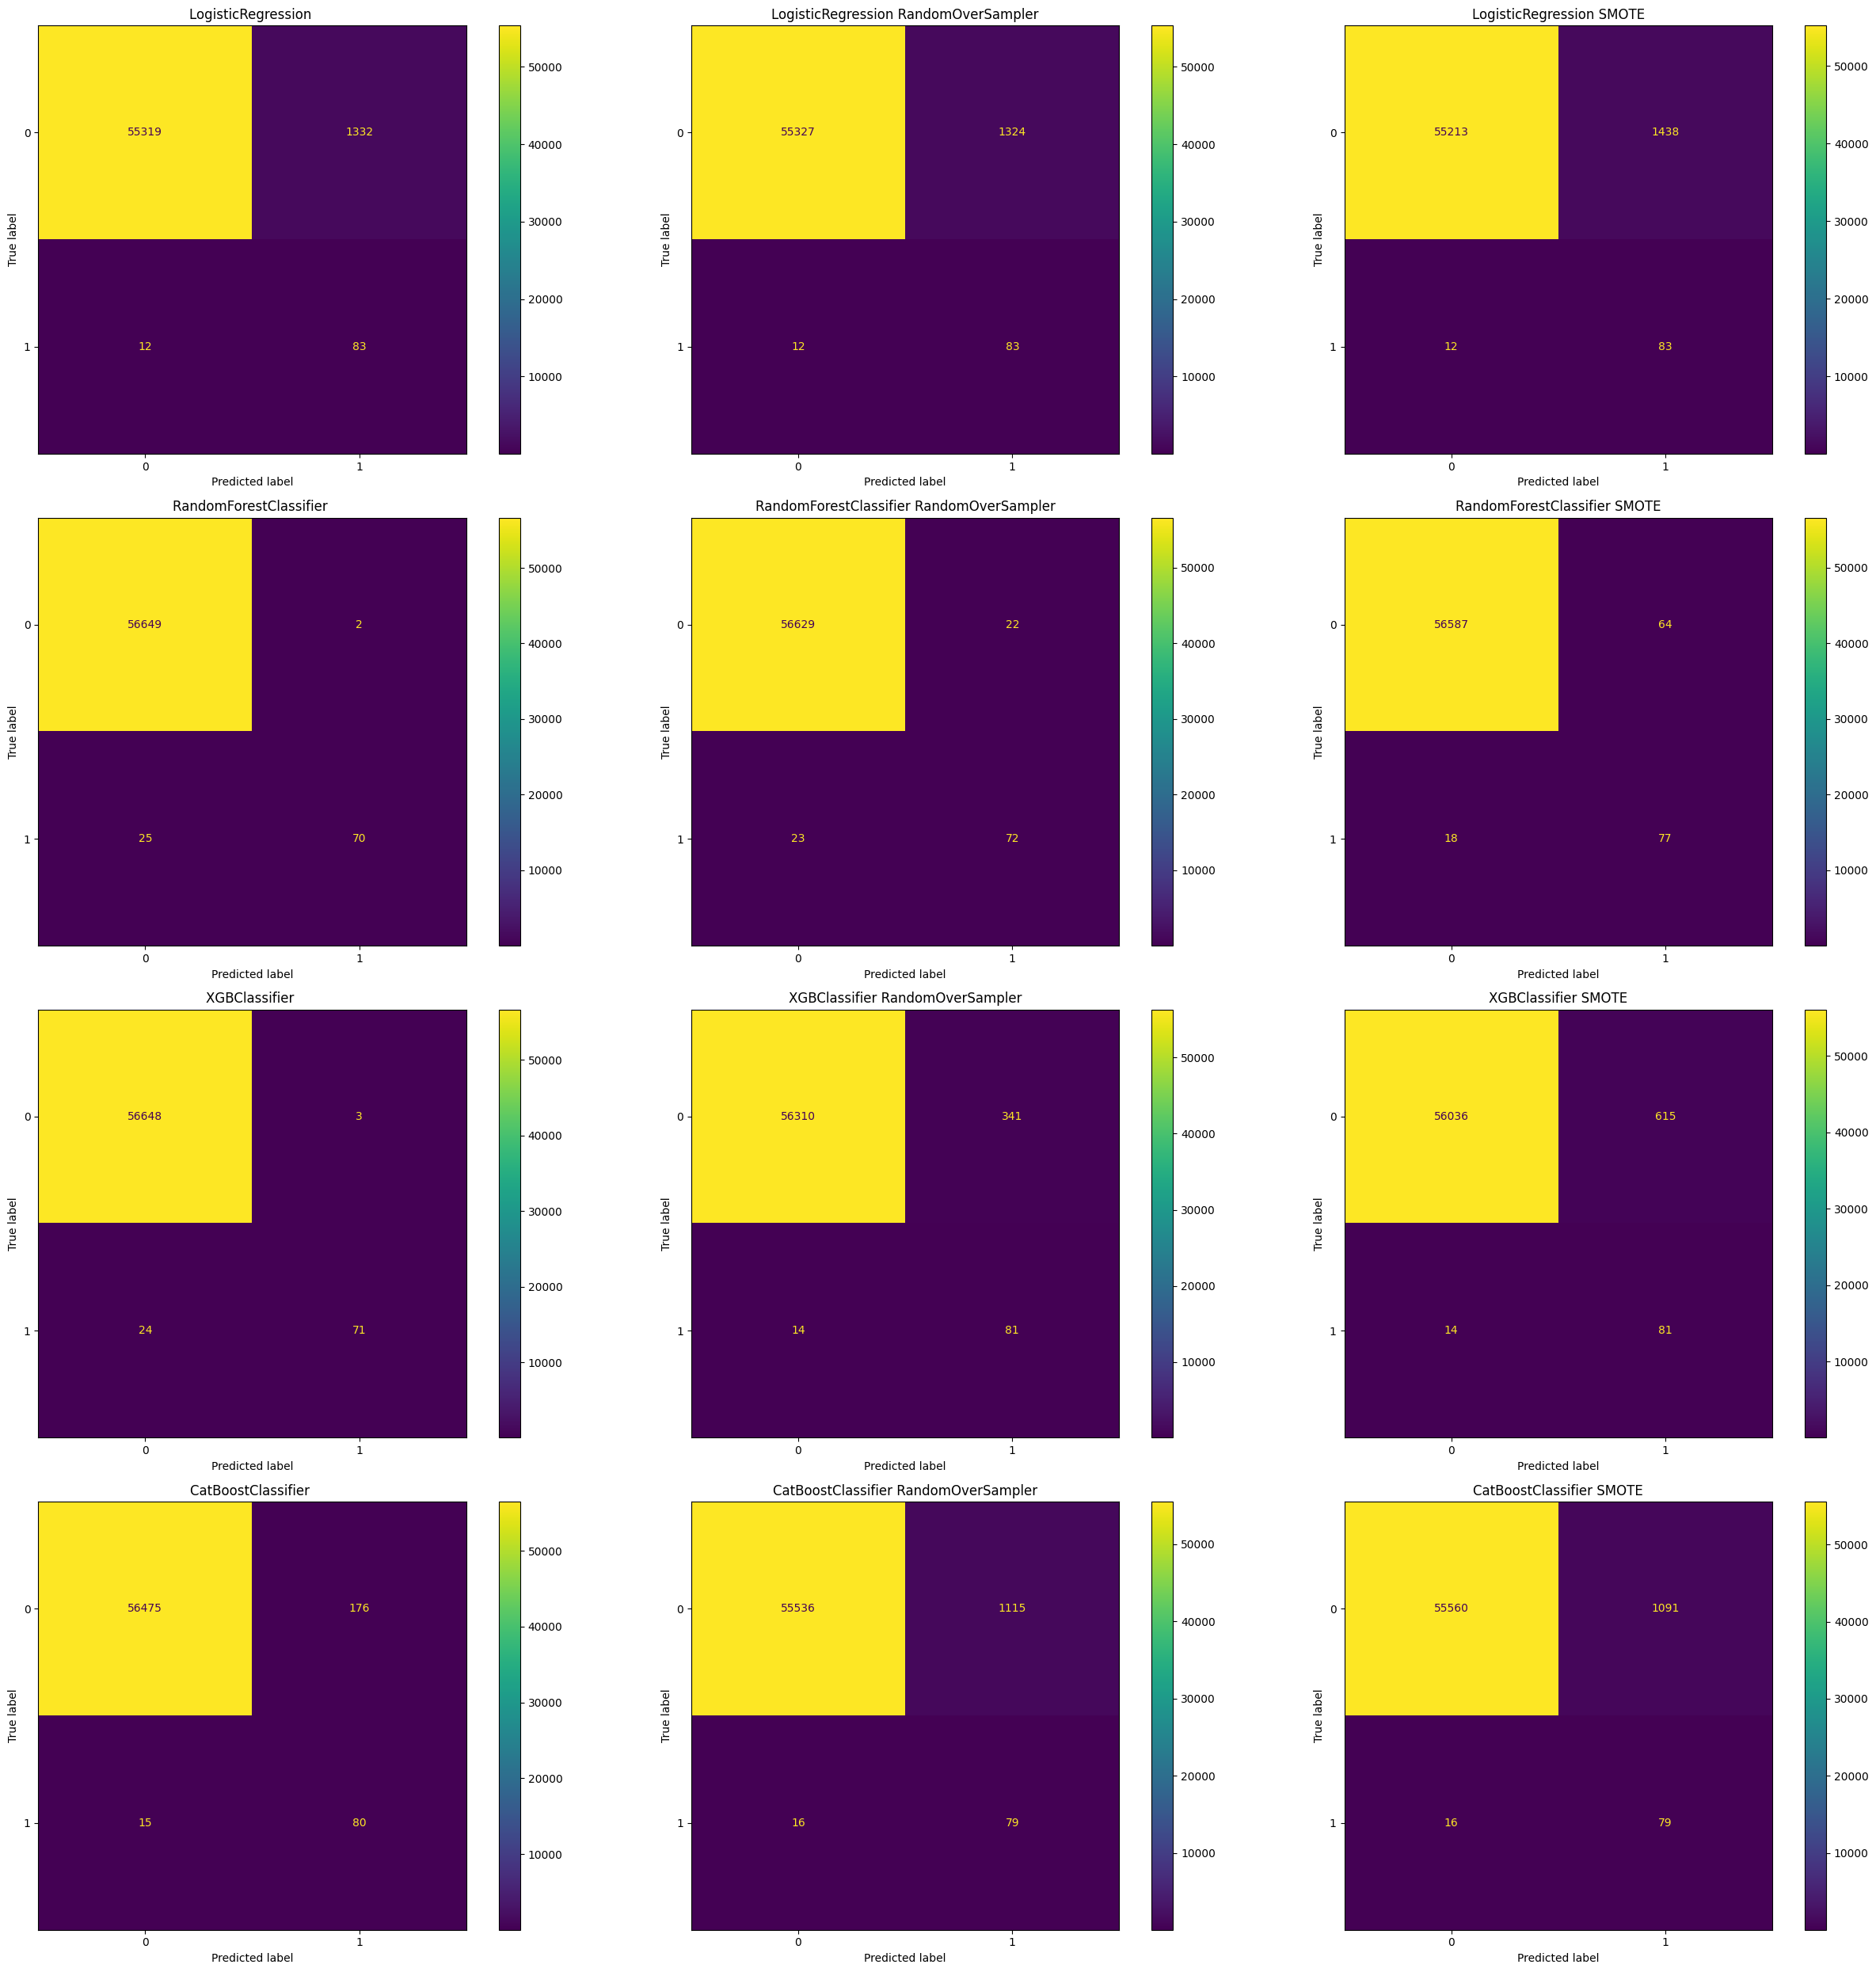

In [27]:
compare_models(X, y, model_params_pairs, methods)

Make it a table.

In [32]:
score_table = pd.DataFrame(columns=['model', 'sampling method', 'f1', 'precision', 'recall', 'roc_auc', 'accuracy'])

X_train, X_test, _, y_true = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

X_test = scale_data_test(X_train, X_test) # scale data with scaler fitted on X_train to exclude leakage possibilities.

for model in models:
    for method in methods:
        clf = load('models/'+type(model).__name__ + '_' + str(method or '')[:-17] + '.joblib')
        y_pred = clf.predict(X_test)
        
        score_table_row = [type(model).__name__, str(method or '')[:-17],
                           f1_score(y_true, y_pred), precision_score(y_true, y_pred),recall_score(y_true, y_pred),
                           roc_auc_score(y_true, y_pred), accuracy_score(y_true, y_pred)]
        
        score_table.loc[len(score_table)] = score_table_row                

score_table

,model,sampling method,f1,precision,recall,roc_auc,accuracy
0,LogisticRegression,,0.109934,0.058657,0.873684,0.925086,0.976316
1,LogisticRegression,RandomOverSampler,0.110519,0.058991,0.873684,0.925157,0.976456
2,LogisticRegression,SMOTE,0.102723,0.054569,0.873684,0.924150,0.974448
3,RandomForestClassifier,,0.838323,0.972222,0.736842,0.868403,0.999524
4,RandomForestClassifier,RandomOverSampler,0.761905,0.765957,0.757895,0.878753,0.999207
5,RandomForestClassifier,SMOTE,0.652542,0.546099,0.810526,0.904698,0.998555
6,XGBClassifier,,0.840237,0.959459,0.747368,0.873658,0.999524
7,XGBClassifier,RandomOverSampler,0.313346,0.191943,0.852632,0.923306,0.993744
8,XGBClassifier,SMOTE,0.204804,0.116379,0.852632,0.920888,0.988916
9,CatBoostClassifier,,0.455840,0.312500,0.842105,0.919499,0.996634


Sort it by recall.

In [31]:
score_table_sorted = score_table.sort_values(by='recall', ascending=False)
score_table_sorted

,model,sampling method,f1,precision,recall,roc_auc,accuracy
0,LogisticRegression,,0.109934,0.058657,0.873684,0.925086,0.976316
1,LogisticRegression,RandomOverSampler,0.110519,0.058991,0.873684,0.925157,0.976456
2,LogisticRegression,SMOTE,0.102723,0.054569,0.873684,0.924150,0.974448
7,XGBClassifier,RandomOverSampler,0.313346,0.191943,0.852632,0.923306,0.993744
8,XGBClassifier,SMOTE,0.204804,0.116379,0.852632,0.920888,0.988916
9,CatBoostClassifier,,0.455840,0.312500,0.842105,0.919499,0.996634
10,CatBoostClassifier,RandomOverSampler,0.122576,0.066164,0.831579,0.905949,0.980069
11,CatBoostClassifier,SMOTE,0.124901,0.067521,0.831579,0.906160,0.980492
5,RandomForestClassifier,SMOTE,0.652542,0.546099,0.810526,0.904698,0.998555
4,RandomForestClassifier,RandomOverSampler,0.761905,0.765957,0.757895,0.878753,0.999207


## Conclusion<a id='conclusion'></a>
[back to table of content](#toc)

Random Forest and XGBoost classifiers both exhibit acceptable recall, precision, and accuracy. The latter scored over 0.999, which might not seem impressive in the context of imbalanced data. However, if we were to mark all transactions as non-fraudulent, we would achieve an accuracy of 0.998. Therefore, we can assert that these models do indeed make a difference.